# Problem Set 4

## by Roussel Desmond Nzoyem


**Important:** _Unless otherwise specified, all error convergence plots (field variable or output) will be presented in "log" mode._

In [146]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/CS3
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/CS3
DeltaMaxRel.npy     FE_matrix.mat      Problem3.ipynb       RB_sample.mat
FE_grid.mat         GitPushPull.ipynb  Problem4_Bckp.ipynb  ZGreedy.npy
FE_matrix_mass.mat  greedySample.npy   Problem4.ipynb


In [147]:
%reset -f

In [148]:
import numpy as np
import numpy.linalg as npalg
import pandas as pd

import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import splu

import timeit
import itertools

import matplotlib.tri as tri
import matplotlib.pyplot as plt

from IPython.display import Image

import warnings

In [149]:
## To ignore warnings ⚠ on Colab 
warnings.filterwarnings('ignore')

In [150]:
plt.style.use("bmh")

In [151]:
## Update Scipy on Colab
%pip install scipy --upgrade

Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.5.4)


### Utility functions adapted from Problem Sets 2 and 3

In [152]:
## Load the given Finite Elements quantities
def loadFEQuantities(tuning):
    AF = loadmat('FE_matrix.mat', simplify_cells=True)
    Ahq = AF['FE_matrix'][tuning]['Ahq']
    Fh = AF['FE_matrix'][tuning]['Fh']

    Mh = loadmat('FE_matrix_mass.mat', simplify_cells=True)['FE_matrix_mass'][tuning]['Mh']
    Lh = np.ones_like(Fh).T @ Mh
    
    return Ahq, Fh, Lh, Mh

## Load the specified sample
def loadSample(sample):
    return loadmat('RB_sample.mat',simplify_cells=True)["RB_sample"][sample]

## Build mubar for the X-inner product
def buildMuBar():
    return np.array([1, 1, 1, 1, 1, 0.1])

## To build a particular mu 
def buildMu(Bi):
    return np.array([1, 1, 1, 1, 1, Bi])

In [153]:
## Assemble A's components, in FE or in RB
def assembleA(mu,Aq):
    A = csc_matrix(Aq[0].shape)
    for k in range(0,6):
        A += mu[k]*Aq[k]
    return A

## Solve the problem in FE or RB, stopping at kStop iterations
def computeSolution(mu, Aq, F, M, g, U0, tMax, K, kStop=None, which=None):
    if kStop is None:    ## Number of iterations to perform
        kStop = K

    dt = tMax/K
    A = assembleA(mu, Aq)

    UkList = np.empty(shape=(A.shape[0], kStop+1))
    UkList[:, 0] = U0

    Uk = U0
    if which=="FE":
        LU = splu(A + M/dt)                     ## Sparse matrix => LU decomposition
        for k in range(1,kStop+1):
            Uk = LU.solve(F*g[k] + (M@Uk)/dt)
            UkList[:, k] = Uk
    elif which=="RB":                           ## No LU decomposition
        for k in range(1,kStop+1):
            Uk = spsolve(A + M/dt, F*g[k] + (M@Uk)/dt)
            UkList[:, k] = Uk
    else:
        print("In which basis do you want the solution?")

    return Uk, UkList

## A function to compute the output, in FE or in RB at any step
def computeOutput(L, Uk):
    return L.T@Uk

 ## Part 1 - Reduced Basis Approximation

In [154]:
## Global paremeters for Part 1.
Ahq, Fh, Lh, Mh = loadFEQuantities("medium")
muBar = buildMuBar()
AhBar = assembleA(muBar, Ahq)

In [155]:
## Control input g

def gKnk(t):    # Kronecker 
    g = np.zeros_like(t)
    g[1] = 1
    return g

def gCos(t):    # Cos
    return 1 - np.cos(t)

In [156]:
## Build the RB matrix, called Z
def buildZ(sample, iterations, Ahq, Fh, Mh, g, U0, tMax, K):
    assert (len(sample) == len(iterations))

    Nmax = len(sample)
    Ncal = Ahq[0].shape[0]
    Z = np.zeros(shape=(Ncal, Nmax))

    for j in range(Nmax):
        Bi, kStop = sample[j], iterations[j]
        mu = buildMu(Bi)

        U, _ = computeSolution(mu, Ahq, Fh, Mh, g, U0, tMax, K, kStop, "FE")
        
        Z[:,j] = U

    return Z

In [157]:
## X-inner product using AhBar
def inner(u,v,AhBar):
    return u.T@AhBar@v

## X-norm
def norm(u,AhBar):
    return np.sqrt(inner(u,u,AhBar))

## Project v on u using AhBar inner product
def proj(v,u,AhBar):
    return inner(u,v,AhBar)*u / inner(u,u,AhBar)

## Gram-Schmidt ortonomalisation
def orthonormalize(Z,AhBar):
    Zorth = np.zeros_like(Z)
    Zorth[:,0] = Z[:,0] / norm(Z[:,0],AhBar)
    N = Z.shape[1]

    for j in range(1,N):
        xj = Z[:,j]
        for k in range(0,j):
            xj -= proj(Z[:,j],Zorth[:,k],AhBar)
        Zorth[:,j] = xj / norm(xj,AhBar)

    return Zorth

## Shorthand for building an orthonormalized RB matrix Z
def buildZorth(sample, iterations, Ahq, Fh, Mh, g, U0, tMax, K, AhBar):
    Z = buildZ(sample, iterations, Ahq, Fh, Mh, g, U0, tMax, K)
    return orthonormalize(Z, AhBar)

In [158]:
## Offline building of necessary RB components
def buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh):
    Anq = []
    for q in range(0,6):
        Anq.append(csc_matrix(Z.T@Ahq[q]@Z))
    
    Mn = Z.T@Mh@Z

    Fn = Z.T@Fh
    Ln = Z.T@Lh

    return Anq, Fn, Ln, Mn  ## A_N^q, F_N, L_N, and M_N

### a) Let's plot the outputs 


**Question:** Plot the outputs $s^k(\mu)$, $s^k_N(\mu)$, and the error $s^k(\mu)- s^k_N(\mu)$ as a function of time for $g(t^k) = 1 − cos(t^k)$ and $\mu = 0.05$.

First, we must build our orthonormalized RB matrix $Z$ using the prescribed sample and iterations; then we shall use it to compute the necessary offline RB quantities $A_{N}^q, F_N, L_N$ and $M_N$. We can finally use those quantities to compute the approximate solution.

*Notice that we use Kronecker's inpluse function $g$ to build the RB matrix, but we use a sinusoidal function when computing our solutions.*


In [159]:
## First, let's build the RB matrix
K = 100
tMax = 10

ZParams = {"sample":[0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1],
            "iterations":[1, 5, 10, 20, 30, 5, 10, 20, 5, 10],
            "K":K,
            "tMax":tMax,
            "U0":np.zeros_like(Fh),
            "Ahq":Ahq,
            "Fh":Fh,
            "Mh":Mh,
            "g":gKnk(np.linspace(0,tMax,K+1)),
            "AhBar":AhBar}
Zfull = buildZorth(**ZParams)

## Next, build the offline quantities
Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Zfull, Ahq, Fh, Lh, Mh)

In [160]:
## Finaly, let's compute the outputs

kStop = K 

## Parameters for the truth output
UhParams = {"mu":buildMu(0.05),
             "K":K,
             "tMax":tMax,
             "kStop":kStop,
             "U0":np.zeros_like(Fh),
             "Aq":Ahq,
             "F":Fh,
             "M":Mh,
             "g":gCos(np.linspace(0,tMax,K+1)),
             "which":"FE"}

## Parameters for the approximate output
UnParams = {"mu":buildMu(0.05),
             "K":K,
             "tMax":tMax,
             "kStop":kStop,
             "U0":np.zeros_like(Fn),
             "Aq":Anq,
             "F":Fn,
             "M":Mn,
             "g":gCos(np.linspace(0,tMax,K+1)),
             "which":"RB"}

Uh, UhList = computeSolution(**UhParams)
Un, UnList = computeSolution(**UnParams)

outputsFE = np.empty((kStop+1))
outputsRB = np.empty((kStop+1))
outputErrors = np.empty((kStop+1))
for k in range(0, kStop+1):
    outputsFE[k] = computeOutput(Lh, UhList[:, k])
    outputsRB[k] = computeOutput(Ln, UnList[:, k])
    outputErrors[k] = np.abs(outputsFE[k] - outputsRB[k])

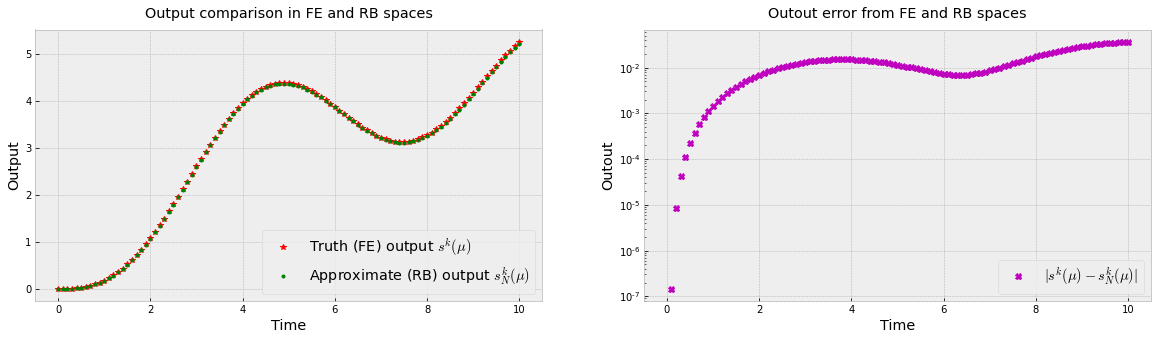

In [161]:
time = np.linspace(0, tMax, K+1)

fig,ax = plt.subplots(1,2,figsize=(10*2,5))
ax[0].plot(time, outputsFE, "r*", label="Truth (FE) output $s^k(\mu)$")
ax[0].plot(time, outputsRB, "g.", label="Approximate (RB) output $s^k_N(\mu)$")

ax[0].set_xlabel("Time", fontsize="x-large")
ax[0].set_ylabel("Output", fontsize="x-large")
# ax[0].set_yscale("log")
ax[0].set_title("Output comparison in FE and RB spaces", fontsize="x-large", y=1.02)
ax[0].legend(fontsize="x-large");

ax[1].plot(time, outputErrors, "mX", label="$\\vert s^k(\mu) - s^k_N(\mu) \\vert$")

ax[1].set_xlabel("Time", fontsize="x-large")
ax[1].set_ylabel("Outout", fontsize="x-large")
ax[1].set_yscale("log")
ax[1].set_title("Outout error from FE and RB spaces", fontsize="x-large", y=1.02)
ax[1].legend(fontsize="x-large");

### b) Let's plot the field variables


**Question:** Plot $|\!|\!| u^k(\mu) |\!|\!|$, $|\!|\!| u^k_N(\mu) |\!|\!|$ and the error $|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|$ as a function of time for $g(t^k) = 1 − cos(t^k)$ and $\mu = 0.05$.

We follow the same steps as in a), then we use the spatio-temporal energy norm to compute the desired quantities (let's remember that $m$ is parameter-independent).
$$
|\!|\!| w^k(\mu) |\!|\!| = \sqrt{m(w^k, w^k) + \sum_{k'=1}^k \Delta t \, a(w^{k'}, w^{k'}; \mu)}
$$


In [162]:
## A function to compute the spatio-temporal energy norm
def energyNorm(WList, Mh, Ah, dt, k):
  Wk = WList[:, k]
  sum = Wk.T@Mh@Wk

  for k_ in range(k):
    Wk_ = WList[:, k_]
    sum += dt * (Wk_.T@Ah@Wk_)

  return np.sqrt(sum)

In [163]:
enNormsFE = np.empty((kStop+1))
enNormsRB = np.empty((kStop+1))
enNormErrors = np.empty((kStop+1))

mu = buildMu(0.05)
Ah = assembleA(mu, Ahq)
dt = tMax / K

for k in range(0, kStop+1):
    enNormsFE[k] = energyNorm(UhList, Mh, Ah, dt, k)
    enNormsRB[k] = energyNorm(Zfull@UnList, Mh, Ah, dt, k)
    enNormErrors[k] = energyNorm(UhList-Zfull@UnList, Mh, Ah, dt, k)

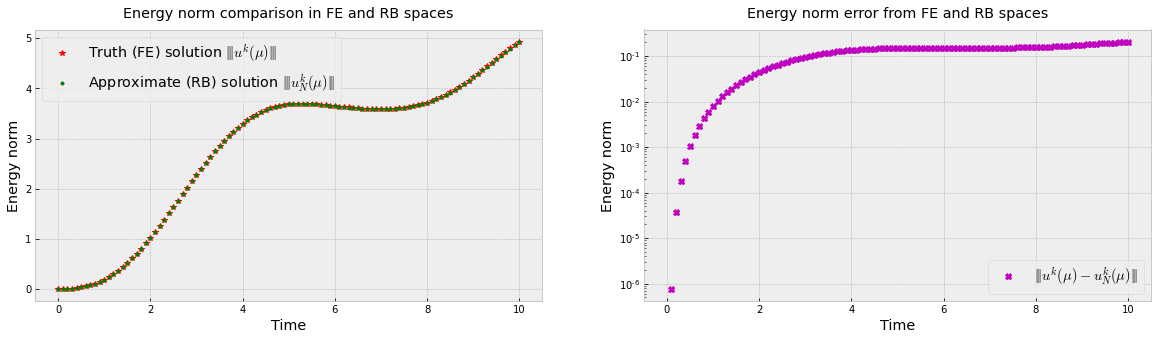

In [164]:
fig,ax = plt.subplots(1,2,figsize=(10*2,5))
ax[0].plot(time, enNormsFE, "r*", label="Truth (FE) solution $|\!|\!|u^k(\mu)|\!|\!|$")
ax[0].plot(time, enNormsRB, "g.", label="Approximate (RB) solution $|\!|\!|u^k_N(\mu)|\!|\!|$")

ax[0].set_xlabel("Time", fontsize="x-large")
ax[0].set_ylabel("Energy norm", fontsize="x-large")
# ax[0].set_yscale("log")
ax[0].set_title("Energy norm comparison in FE and RB spaces", fontsize="x-large", y=1.02)
ax[0].legend(fontsize="x-large");

ax[1].plot(time, enNormErrors, "mX", label="$|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|$")

ax[1].set_xlabel("Time", fontsize="x-large")
ax[1].set_ylabel("Energy norm", fontsize="x-large")
ax[1].set_yscale("log")
ax[1].set_title("Energy norm error from FE and RB spaces", fontsize="x-large", y=1.02)
ax[1].legend(fontsize="x-large");

 ## Part 2 - A Posterior Error Estimation

In [165]:
K = 100
tMax = 10

## For this part, the RB matrix will still be
ZParams = {"sample":[0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1],
            "iterations":[1, 5, 10, 20, 30, 5, 10, 20, 5, 10],
            "K":K,
            "tMax":tMax,
            "U0":np.zeros_like(Fh),
            "Ahq":Ahq,
            "Fh":Fh,
            "Mh":Mh,
            "g":gKnk(np.linspace(0,tMax,K+1)),
            "AhBar":AhBar}
Zfull = buildZorth(**ZParams)

## RB quantities
Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Zfull, Ahq, Fh, Lh, Mh)

### The base parameters for any RB solution computation
baseUnParams = {"mu":buildMu(0.05),
                "K":K,
                "tMax":tMax,
                "kStop":K,
                "U0":np.zeros_like(Fn),
                "Aq":Anq,
                "F":Fn,
                "M":Mn,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"RB"}

Un, UnList = computeSolution(**baseUnParams)

### a) Offline-online version for the a posteriori error bound

The goal is to derive and implement an offline-online version for the calculation of the energy norm error bound. Let's start by providing the framework for the calculation.

The computation of the error bound revolves arround the computation of the Riesz representation for the residual $r^k$. For any $v \in X$, we have

\begin{align*}
(\hat e^k(\mu), v)_X &= r^k (v; \mu) \\
&= f(v)g(t^k) - m\left( \frac{u^k_N(\mu) - u^{k-1}_N(\mu)}{\Delta t}, v \right) - a(u^k_N(\mu), v;\mu)
\end{align*}

After expressing the solution in the RB basis $X_N = \text{span}\{\xi_1, \ldots \xi_N\}$, we get

\begin{align*}
(\hat e^k(\mu), v)_X = f(v)g(t^k) - \sum_{n=1}^N \frac{u^k_{N,n}(\mu) - u^{k-1}_{N,n}(\mu)}{\Delta t} m\left(\xi_n , v \right) - \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N,n}(\mu)\, \theta^q(\mu) \, a^q(\xi_n, v)
\end{align*}

For convenience, ***let's drop the dependence in $\mu$ in our notations***. By posing $w^k_N = \dfrac{u^k_N - u^{k-1}_N}{\Delta t} $, we can use the superposition principle to express $\hat e^k$ as

\begin{align*}
\hat e^k = g(t^k)C + \sum_{n=1}^N w^k_{N,n} R_n + \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N,n} \, \theta^q \, L^q_n
\end{align*}

where the vectors $C, R_n$, and $L_n^q$ are computed by solving the equations below

\begin{align*}
\bar{A}_{\cal N}C &= F_{\cal N} \\
\bar{A}_{\cal N}R_n &= - M_{\cal N} (Z^T)_n \\
\bar{A}_{\cal N}L_n^q &= - A^q_{\cal N} (Z^T)_n 
\end{align*}

where $(Z^T)_n$ is meant to represent the $n$-th column of the RB matrix $Z$.

To compute the norm of the Riesz representation, we can perform the X-inner product below

\begin{align*}
(\hat e^k, \hat e^k)_X &= g(t^k)^2 \underbrace{(C,C)_X}_{\text{CC}} + 2 g(t^k) \sum_{n=1}^N w^k_{N,n} \underbrace{(C,R_n)_X}_{\text{CR}_n} + 2 g(t^k) \sum_{q=1}^{Q} \sum_{n=1}^N u^k_{N,n} \theta^q \underbrace{(C,L^q_n)_X}_{\text{CL}_n^q} \\
&+ 2 \sum_{q=1}^{Q} \sum_{n=1}^N \sum_{n'=1}^{N} u^k_{N,n} \theta^q w^k_{N,n} u^k_{n'} \underbrace{(R_n,L^q_{n'})_X}_{\text{RL}_{n,n'}^q} + \sum_{n=1}^N \sum_{n'=1}^{N'} w^k_{N,n} \, w^k_{N,n'} \underbrace{(R_n,R_{n'})_X}_{\text{RR}_{n, n'}} \\
&+ \sum_{q=1}^{Q} \sum_{q'=1}^{Q} \sum_{n=1}^N \sum_{n'=1}^{N} \theta^q \theta^{q'} u^k_{N,n} u^k_{N,n'} \underbrace{(L_n^q,L^{q'}_{n'})_X}_{\text{LL}^{q, q'}_{n, n'}} 
\end{align*}

Using inner products, this forumla can easily be written as

\begin{align*}
(\hat e^k, \hat e^k)_X  &= g(t^k)^2 (\text{CC}) + 2 g(t^k) (w^k)^T(\text{CR}) + 2 g(t^k) \sum_{q=1}^Q \theta^q (u^k_N)^T (\text{CL}^q) \\ &
+ 2\sum_{q=1}^Q \theta^q (w^k_N)^T (\text{RL}^q) (u^k_{N}) + (w^k)^T (\text{RR}) (w^k) \\
&+  \sum_{q=1}^Q \sum_{q'=1}^Q \theta^q \theta^{q'} (u^k_N)^T (\text{LL}^{q,q'}) (u^k_{N})
\end{align*}

The quantities $\text{CC}$, $\text{CR}$, $\text{CL}^q$, $\text{RL}^q$, $\text{RR}$, and $\text{LL}^{q, q'}$ are all computed and stored offline, and the other quantities are parameter-dependent and thus computed online. During the online stage, we need to perform the indicated dot products, and sum the results appropriately. Finaly the square root of the result yields the desired X-norm of the Riesz representation 

$$
\Vert \hat e^k(\mu) \Vert_X = \sqrt{(\hat e^k(\mu), \hat e^k(\mu))_X}
$$

Continuing online, we can use the below formula to compute the energy norm error bound

$$
\Delta_N^k(\mu) = \alpha_{LB}^{-1/2}(\mu) \left( \sum_{k'=1}^k \Delta t \Vert \hat e^{k'}(\mu) \Vert_X^2  \right) ^{1/2}
$$

where  $\alpha_{LB}(\mu)$ is obtained by a min-theta approach.

Now let's implement the technique.

In [166]:
## Lower bound for alpha using Min-Theta
def minTheta(mu):
    return min([1, 10*mu[-1]])

## Norm of the Riesz representation - OFFLINE PHASE
def buildOfflineRieszQuantities(Ahq, Fh, Mh, AhBar, Z):
    Qmax = 6

    C = spsolve(AhBar, Fh)
    CC = C.T@AhBar@C

    R = spsolve(AhBar, -Mh@Z)
    CR = C.T@AhBar@R
    RR = R.T@AhBar@R

    L = []
    for q in range(1,Qmax+1):
        L.append(spsolve(AhBar, -Ahq[q-1]@Z))

    CL = []
    for q in range(1,Qmax+1):
        CL.append(C.T@AhBar@L[q-1])

    RL = []
    for q in range(1,Qmax+1):
        RL.append(R.T@AhBar@L[q-1])

    LL = []
    for q in range(1,Qmax+1):
        LLq = []
        for q_ in range(1,Qmax+1):
            LLq.append(L[q-1].T@AhBar@L[q_-1])
        LL.append(LLq)

    return CC, CR, RR, CL, RL, LL

## Norm of the Riesz representation - ONLINE PHASE
def eHatRieszNormRB(mu, k, UnList, g, K, tMax, CC, CR, RR, CL, RL, LL):
    Qmax = 6
    
    assert k < UnList.shape[1], "Seules %d itérations ont été faites"%UnList.shape[1]
    assert k > 0, "Fournissez un k > 0"
    N = UnList.shape[0]
    assert N <= CR.shape[0], "N must be lower than N_max"

    dt = tMax/K
    Uk = UnList[:, k]
    Wk = (UnList[:, k] - UnList[:, k-1]) / dt

    eHatNorm = CC*(g[k]**2) + 2*g[k]*Wk.T@CR[:N] + Wk.T@RR[:N,:N]@Wk
    for q in range(1, Qmax+1):
        eHatNorm += 2*mu[q-1]*(Wk.T@RL[q-1][:N,:N]@Uk)
        eHatNorm += 2*mu[q-1]*g[k]*(Uk.T@CL[q-1][:N])
        for q_ in range(1, Qmax+1):
            eHatNorm += mu[q-1]*mu[q_-1]*(Uk.T@(LL[q-1][q_-1][:N,:N])@Uk)
        
    # if eHatNorm < 0:
    # #     print("k=", k, "   Negative norm found:", eHatNorm)
    #     eHatNorm = 0

    return np.sqrt(eHatNorm)

## A function to compute the error bound: 'params' are the same as for 'eHatRieszNormRB'
def offlineOnlineErrorBound(params, k):
    mu = params["mu"]
    dt = params["tMax"] / params["K"]
    alphaLB = minTheta(mu)

    Delta = 0
    for k_ in range(1, k+1):
        params["k"] = k_
        eHatNorm = eHatRieszNormRB(**params)
        Delta += dt * eHatNorm**2
    
    return np.sqrt(Delta) / np.sqrt(alphaLB)

In [167]:
### Let's build our offline quantities 
RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Zfull}
CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)
print("CC", CC)
print("Shape RR:", RR.shape)
print("Total Len LL:", len(LL)*len(LL))

CC 1.598766527030964
Shape RR: (10, 10)
Total Len LL: 36


In [168]:
### A test defining the base parameters for the computation of the Riesz representaion
baseOnlineOfflineParams = {"mu":baseUnParams['mu'], 
                            "k":baseUnParams['K']//2, 
                            "UnList":UnList, 
                            "g":baseUnParams["g"], 
                            "K":baseUnParams["K"], 
                            "tMax":baseUnParams["tMax"], 
                            "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

eHatNorm = eHatRieszNormRB(**baseOnlineOfflineParams)
print("Test Base Riez Norm for k = %d:"%baseOnlineOfflineParams["k"], eHatNorm)

alphaLB = minTheta(baseOnlineOfflineParams["mu"])
print("Test Alpha Lower Bound:", alphaLB)

errorBound  = offlineOnlineErrorBound(baseOnlineOfflineParams, baseOnlineOfflineParams["k"])
print("Test Base Error Bound With Online-Offline:", errorBound)

Test Base Riez Norm for k = 50: 0.037271486568207335
Test Alpha Lower Bound: 0.5
Test Base Error Bound With Online-Offline: 0.21243394881264227


### Direct calculation for the error bound

The direct calculation is straightforward:
$$
(\hat e (\mu), v)_X = r(v;\mu)
$$ 
using  $w^k_N(\mu) = \dfrac{u^k_N(\mu) - u^{k-1}_N(\mu)}{\Delta t} $, this leads to
$$
\bar A_{\cal N} \hat e (\mu) = F_{\cal N} g(t^k) - M_{\cal N}(Z w_N^k(\mu)) - A_{\cal N}(\mu)(Z u_N^k(\mu))
$$
Here, the lower bound for the coercivity constant will be computed by solving a generalized eigen value problem. However, this method is slow; for performance reasons, we migh use the much faster min-theta approach.

In [169]:
## Compute continuity and coercity constants by solving a generalized eigen value problem
def computeCoercivityLB(mu, Ahq, AhBar):
    Ah = assembleA(mu,Ahq)
    alphaLB = eigsh(Ah, M=AhBar, k=1, which='SM', return_eigenvectors=False)[0]
    return alphaLB

## Norm of the Riesz representation
def eHatRieszNormFE(mu, k, UnList, g, K, tMax, Ahq, Fh, Mh, AhBar, Zfull):
    Qmax = 6
    
    assert k < UnList.shape[1], "Seules %d itérations ont été faites"%UnList.shape[1]
    assert k > 0, "Fournissez un k > 0"
    N = UnList.shape[0]
    assert N <= Zfull.shape[0], "N must be lower than N_max"
    Z = Zfull[:, :N]

    Uk = UnList[:, k]

    dt = tMax/K
    Wk = (UnList[:, k] - UnList[:, k-1]) / dt

    Ah = assembleA(mu, Ahq)

    Rmu = Fh*g[k] - Mh@(Z@Wk) - Ah@(Z@Uk)
    eHat = spsolve(AhBar, Rmu)

    return norm(eHat, AhBar)

## A function to compute the error bound: 'baseParams' are the same as for 'eHatRieszNormFE'
def directErrorBound(params, k):
    mu = params["mu"]
    dt = params["tMax"] / params["K"]
    Ahq = params["Ahq"] 
    AhBar = params["AhBar"]

    # alphaLB = computeCoercivityLB(mu,Ahq,AhBar)   ###------USE THIS FOR PRECISION-------##########
    alphaLB = minTheta(mu)                         

    Delta = 0
    for k_ in range(1, k+1):
        params["k"] = k_
        eHatNorm = eHatRieszNormFE(**params)
        Delta += dt * eHatNorm**2
    
    return np.sqrt(Delta) / np.sqrt(alphaLB)

In [170]:
### A test defining the base parameters
baseDirectParams = {"mu":baseUnParams['mu'], 
                    "k":baseUnParams['K']//2, 
                    "UnList":UnList, 
                    "g":baseUnParams["g"], 
                    "K":baseUnParams["K"], 
                    "tMax":baseUnParams["tMax"], 
                    "Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Zfull":Zfull}

eHatNorm = eHatRieszNormFE(**baseDirectParams)
print("Test Base Riez Norm for k = %d:"%baseDirectParams["k"], eHatNorm)

# alphaLB = computeCoercivityLB(baseDirectParams["mu"], Ahq, AhBar)           ########--------Print this---------#########
# print("Test alpha lower bound:", alphaLB)

errorBound  = directErrorBound(baseDirectParams, baseUnParams["K"])
print("Test Base Error Bound With Online-Offline:", errorBound)

Test Base Riez Norm for k = 50: 0.037271486568083295
Test Base Error Bound With Online-Offline: 0.289778168740655


### b) Comparison of the two methods over time

Now let's compare the two approaches for the error bound calculation for 10
random parameter values in the test sample.

In [171]:
nTest = 10
BiVals = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTest)))

K = baseUnParams["K"]
nStepsToPlot = 5
onOffData = np.zeros((nTest, nStepsToPlot+1))
directData = np.zeros((nTest, nStepsToPlot+1))

for i, Bi in enumerate(BiVals):

    baseUnParams["mu"] = buildMu(Bi)
    Un, UnList = computeSolution(**baseUnParams)

    baseOnlineOfflineParams["mu"] = baseUnParams["mu"]
    baseOnlineOfflineParams["UnList"] = UnList

    baseDirectParams["mu"] = baseUnParams["mu"]
    baseDirectParams["UnList"] = UnList

    for j, k in enumerate(range(0, K+1, K//nStepsToPlot)):
        if k==0: 
            onOffData[i, j] = offlineOnlineErrorBound(baseOnlineOfflineParams, k+1)
            directData[i, j] = directErrorBound(baseDirectParams, k+1)
        else:
            onOffData[i, j] = offlineOnlineErrorBound(baseOnlineOfflineParams, k)
            directData[i, j] = directErrorBound(baseDirectParams, k)

In [172]:
## A function to print tables in the form of dataframes
def printTable(DeltaList, BiVals, steps, mask=None, title=None):
    if title is None:
        title = "----- Energy error bound -------"
    print(title)

    if mask is None:
        mask = list(np.arange(len(DeltaList[:,0])))

    df = pd.DataFrame({"Time step":steps})

    for i, Bi in enumerate(BiVals):
        df["mu = "+str(np.round(Bi, 3))] = DeltaList[i][mask]

    display(df)

In [173]:
mask = list(np.arange(0, nStepsToPlot+1))
steps = np.arange(0, K+1, K//nStepsToPlot)
steps[0] = 1

title="----- Offline-Online decomposition -------"
printTable(onOffData, BiVals, steps, mask=mask, title=title)

print()
title="----- Direct calculation -------"
printTable(directData, BiVals, steps, mask=mask, title=title)

----- Offline-Online decomposition -------


,Time step,mu = 0.023,mu = 0.014,mu = 0.038,mu = 0.029,mu = 0.404,mu = 0.501,mu = 0.031,mu = 0.072,mu = 0.01
0,1,0.000002,5.616233e-07,0.000003,0.000002,0.000023,0.000029,0.000002,0.000004,2.463568e-08
1,20,0.101600,1.334311e-01,0.079920,0.091512,0.048851,0.049139,0.088241,0.057647,1.544483e-01
2,40,0.284160,3.729873e-01,0.223716,0.256025,0.141203,0.142593,0.246905,0.161743,4.316647e-01
3,60,0.313208,4.115818e-01,0.246462,0.282118,0.158383,0.160082,0.272048,0.178159,4.766792e-01
4,80,0.336360,4.554468e-01,0.258616,0.299687,0.162755,0.164400,0.287968,0.183714,5.353298e-01
5,100,0.466009,6.610692e-01,0.343405,0.407352,0.206933,0.209052,0.388881,0.234853,7.931134e-01



----- Direct calculation -------


,Time step,mu = 0.023,mu = 0.014,mu = 0.038,mu = 0.029,mu = 0.404,mu = 0.501,mu = 0.031,mu = 0.072,mu = 0.01
0,1,0.000002,5.616233e-07,0.000003,0.000002,0.000023,0.000029,0.000002,0.000004,2.463405e-08
1,20,0.101600,1.334311e-01,0.079920,0.091512,0.048851,0.049139,0.088241,0.057647,1.544483e-01
2,40,0.284160,3.729873e-01,0.223716,0.256025,0.141203,0.142593,0.246905,0.161743,4.316647e-01
3,60,0.313208,4.115818e-01,0.246462,0.282118,0.158383,0.160082,0.272048,0.178159,4.766792e-01
4,80,0.336360,4.554468e-01,0.258616,0.299687,0.162755,0.164400,0.287968,0.183714,5.353298e-01
5,100,0.466009,6.610692e-01,0.343405,0.407352,0.206933,0.209052,0.388881,0.234853,7.931134e-01


The tables show that the two tehniques yield exactly the same results. Let's plot these results.

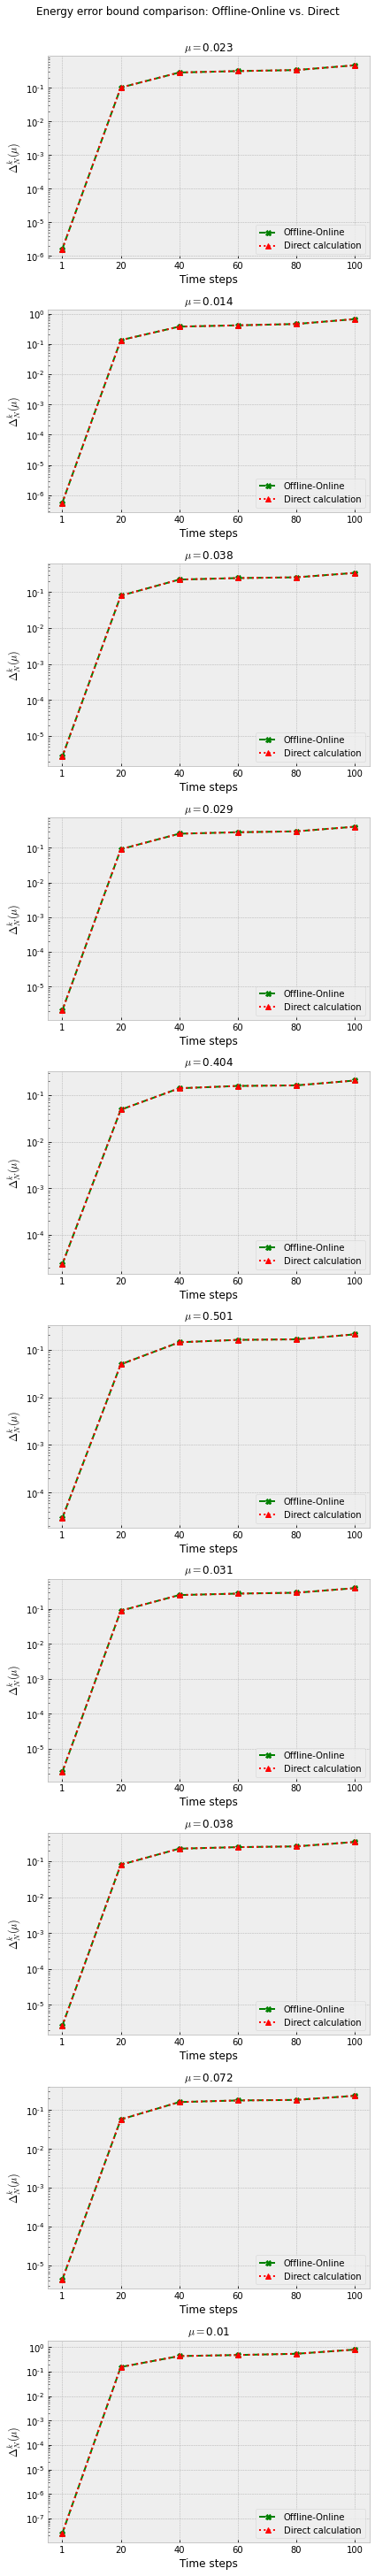

In [174]:
ticks = list(np.arange(0, nStepsToPlot+1))
ticklabels = list(np.arange(0, K+1, K//nStepsToPlot))
ticklabels[0] = 1

fig,ax = plt.subplots(nTest, 1, figsize=(6, 4*nTest))

for i, Bi in enumerate(BiVals):   
    ax[i].plot(onOffData[i], "gX--", label="Offline-Online")
    ax[i].plot(directData[i], "r^:", label="Direct calculation")

    ax[i].set_xlabel("Time steps", fontsize="large")
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(ticklabels)
    ax[i].set_ylabel("$\Delta_N^{k}(\mu)$", fontsize="large")
    ax[i].set_yscale("log")
    ax[i].set_title("$\\mu=$"+str(np.round(Bi, 3)), fontsize="large")
    ax[i].legend();

plt.suptitle("Energy error bound comparison: Offline-Online vs. Direct", fontsize="large", y=1.01)
plt.tight_layout();

The results are exactly the same. Let's note however that the offine-online decomposition (which relies on a summation during its online stage) might produce values too close to the machine epsilon, and negative; thus causing NaN values when square-rooted. 

### c) Offline-online version for the a posteriori output error bound

Here, the goal is to derive and implement and offline-online version for the a porteriori error bound for the output variable $s$. This computation will help in the following sections. The formula we will use for this section is
$$
\Delta_N ^{s,k} = \sigma_{LB}^{-1} \left( \sup_{v\in X} \frac{l(v;\mu)}{\Vert v \Vert} \right) \Delta_N^k(\mu)
$$

1. We first need to compute the norm of Riesz representation for the output linear function $\hat l (\mu) = \sup_{v\in X} \frac{l(v;\mu)}{\Vert v \Vert}$. This done offline by solving 
$$
\bar A_{\cal N} \hat l(\mu) = L_{\cal N}
$$

2. After that, we will use the offline-online decomposition to compute the energy norm error bound $\Delta_N^k(\mu)$ using our functions from the previous section.

3. Finaly, The value for $m$'s coercivity constant $\sigma_{LB}$ is 1 according to the definition of the $L^2$ norm, and the fact that the bilinear form $m(\cdot, \cdot)$ is paremeter-independent i.e $$m(u,v;\mu) = m(u,v;\bar \mu) = m(u,v)$$ and the generalized eigen-value problem 
$$
Mv = \lambda \bar{M}v  \Longrightarrow  (1-\lambda) v = 0
$$ 
has 1 as the single eigen-value.

The 3 components above (computed independently) show that computing the output error bound mixes Offline-Online and Direct computation.

In [175]:
## A function to compute \hat l's norm
def lHatRieszNorm(Fh, Lh, AhBar):
    lHat = spsolve(AhBar, Lh)
    return norm(lHat, AhBar)

In [176]:
lHatNorm = lHatRieszNorm(Fh, Lh, AhBar)

In [177]:
## A function to compute sigma_LB (which equals 1) 
def computeSigmaCoercivity(mu, Mh, MhBar):
    Ah = assembleA(mu, Mh)
    sigmaLB = eigsh(Mh, M=MhBar, k=1, which='SM', return_eigenvectors=False)[0]
    return sigmaLB

In [178]:
## A function to compute the error bound: 'params' are the same as for 'eHatRieszNormRB'
def outputErrorBound(params, Mh, lHatNorm, k):
    mu = params["mu"]
    dt = params["tMax"] / params["K"]

    alphaLB = minTheta(mu)
    sigmaLB = computeSigmaCoercivity(mu, Mh, Mh)

    Delta = 0
    for k_ in range(1, k+1):
        params["k"] = k_
        eHatNorm = eHatRieszNormRB(**params)
        Delta += dt * eHatNorm**2
    Delta = np.sqrt(Delta) / np.sqrt(alphaLB)

    return lHatNorm*Delta / sigmaLB

In [179]:
nTest = 5
BiVals = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTest)))

K = baseUnParams["K"]
nStepsToPlot = 10
onOffOutputData = np.zeros((nTest, nStepsToPlot+1))

baseOutputParams = {"mu":baseUnParams['mu'], 
                    "k":baseUnParams['K']//2, 
                    "UnList":UnList, 
                    "g":baseUnParams["g"], 
                    "K":baseUnParams["K"], 
                    "tMax":baseUnParams["tMax"], 
                    "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

for i, Bi in enumerate(BiVals):

    baseUnParams["mu"] = buildMu(Bi)
    Un, UnList = computeSolution(**baseUnParams)

    baseOutputParams["mu"] = baseUnParams["mu"]
    baseOutputParams["UnList"] = UnList

    for j, k in enumerate(range(0, K+1, K//nStepsToPlot)):
        if k==0: 
            onOffOutputData[i, j] = outputErrorBound(baseOutputParams, Mh, lHatNorm, k+1)
        else:
            onOffOutputData[i, j] = outputErrorBound(baseOutputParams, Mh, lHatNorm, k)

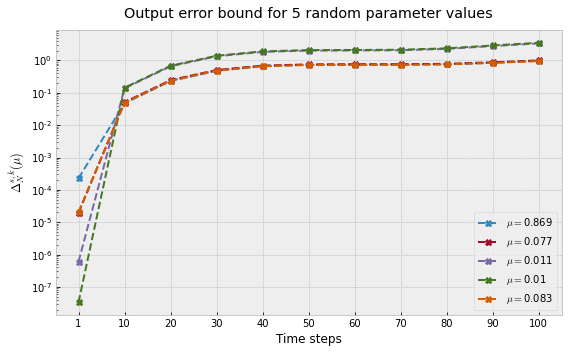

In [180]:
ticks = list(np.arange(0, nStepsToPlot+1))
ticklabels = list(np.arange(0, K+1, K//nStepsToPlot))
ticklabels[0] = 1

fig,ax = plt.subplots(1, 1, figsize=(8, 5))

for i, Bi in enumerate(BiVals):   
    ax.plot(onOffOutputData[i], "X--", label="$\\mu=$"+str(np.round(Bi, 3)))

ax.set_xlabel("Time steps", fontsize="large")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_ylabel("$\Delta_N^{s, k}(\mu)$", fontsize="large")
ax.set_yscale("log")
ax.set_title("Output error bound for 5 random parameter values", fontsize="x-large", y=1.02)
ax.legend();

plt.tight_layout();

 ## Part 3 - Sampling Procedure

The POD$(t)$-Greedy$(\mu)$ is an efficient algorithm to construct an optimal RB sample. The details for the POD$(t)$ algorithm are carefully explained in the lecture notes for this course (p. 96). Its main steps are:

1. Form a correlation matric $$C^{POD}_{i,j} = \frac{1}{K} (u^i(\mu), u^j(\mu))_X, \, \, 1 \leq  i, j \leq K$$

2. Solve the eigenpair corresponding to the largest eigenvalue $\lambda^{POD, max}$ from 

$$
C^{POD} \phi^{POD, k} =  \lambda^{POD, k} \phi^{POD, k}
$$

3. Compute the largest POD mode (that will be added to our RB basis in construction)
$$
\Phi^{POD, 1} = \sum_{k=1}^K \phi^{POD, max}_k u^k(\mu)
$$

All this done, we can move to the Greedy$(\mu)$ stage. We are familiar with the inner-workings of this algorithm as we have encountered it in Problem Set 3.

In [93]:
## Project a list of vectors (v) on u using AhBar inner product
def projectGroup(v,u,AhBar):
    return inner(u,v,AhBar)*u[:, np.newaxis] / inner(u,u,AhBar)

In [94]:
## Projection of u on X_N using Gram-Scmidt
def GramSchmidt(Z, u, AhBar):
    nbCol = Z.shape[1]
    
    if nbCol == 0 or len(Z) == 0:   ## Z is empty ==> shape is (0,)
        z = u

    else:
        z = u
        for k in range(0, nbCol):
            z -= projectGroup(u, Z[:,k], AhBar)

        # for k in range(z.shape[1]):
        #     z[:, k] = z[:, k] / norm(z[:, k], AhBar)

    return z

In [95]:
## Form the correlation matrix
def buildCorrelationMatrix(UkListProj, AhBar):
  K = UkListProj.shape[1]
  C = np.zeros((K,K))
  
  for i in range(K):
      for j in range(K):
          if j >= i:
              C[i,j] = UkListProj[:,i].T@AhBar@UkListProj[:,j]
              C[j,i] = C[i,j]

  return C / K

## Find and utilize the largest POD mode
def performPOD(UkListProj, AhBar):
    C = buildCorrelationMatrix(UkListProj, AhBar)

    modVal, modVec = eigsh(C, k=1, which="LM")
    modVec = np.real(modVec)
    
    K = C.shape[0]
    NCal = UkListProj.shape[0]

    Upod = np.zeros((NCal))
    for i in range(K):
        Upod += modVec[i]*UkListProj[:,i]

    return Upod

In [96]:
## Reshape is important when the size is 1; the matrices are scalars in numpy
def reshapeQuantities(CC, CR, RR, CL, RL, LL):
    CR = np.array([CR])
    RR = np.array([RR])[:, np.newaxis]
    Qmax = 6
    for q in range(0,Qmax):
      CL[q] = np.array([CL[q]])
      RL[q] = np.array([RL[q]])[:, np.newaxis]
      for q_ in range(0, Qmax):
        LL[q][q_] = np.array([LL[q][q_]])[:, np.newaxis]
    return CC, CR, RR, CL, RL, LL

In [97]:
## Compute max delta rel over train sample
def maxDeltaGreedy(trainSample, Z, Ahq, Fh, Lh, Mh, AhBar, tMax, K):

    ## --------- First of all, build RB quantities ----------------
    Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)

    ## --------- Second, define base parameters for Un computation in RB space ----------------
    UnParams = {"mu":None, "K":K, "tMax":tMax, "kStop":K, "U0":np.zeros_like(Fn),
                "Aq":Anq, "F":Fn, "M":Mn,
                "g":gKnk(np.linspace(0,tMax,K+1)), "which":"RB"}

    ## --------- Compute offline quantities for the Riesz Norm ----------------
    RieszParamsOffline = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Z}
    CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszParamsOffline)
    if (Z.shape[1]==1):   ## Put arrays in correct shapes
        CC, CR, RR, CL, RL, LL = reshapeQuantities(CC, CR, RR, CL, RL, LL)

    ## ------ Base params for computation of the Riesz Norm online phase-------------
    RieszParamsOnline = {"mu":None,  "k":UnParams['K'], "UnList":None, 
                          "g":UnParams["g"], "K":UnParams["K"], "tMax":UnParams["tMax"], 
                          "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

    DeltaMaxRel = -1
    muOpt = None

    for j, Bi in enumerate(trainSample):

        mu = buildMu(Bi)

        UnParams["mu"] = mu
        Un, UnList = computeSolution(**UnParams)
        
        Ah = assembleA(mu, Ahq)
        dt = K / tMax
        UnKnorm = energyNorm(Z@UnList, Mh, Ah, dt, K) 

        RieszParamsOnline["mu"] = mu
        RieszParamsOnline["UnList"] = UnList
        DeltaMax  = offlineOnlineErrorBound(RieszParamsOnline, K)

        DeltaRel = DeltaMax / UnKnorm

        if DeltaRel > DeltaMaxRel:
        # if j==0 or (DeltaRel > DeltaMaxRel and np.isnan(DeltaRel)==False):
        # if j==0 or DeltaRel > DeltaMaxRel:
            DeltaMaxRel = DeltaRel
            muOpt = mu

    return DeltaMaxRel, muOpt

In [98]:
def greedyPODSampling(trainSample, Ahq, Fh, Lh, Mh, AhBar, tMax, K, mu0, tol):
    
    ## --- Define Base Uh params for Uh computation in FE space
    UhParams = {"mu":None, "K":K, "tMax":tMax, "kStop":K, "U0":np.zeros_like(Fh), 
                "Aq":Ahq, "F":Fh, "M":Mh,
                "g":gKnk(np.linspace(0,tMax,K+1)), "which":"FE"}

    ## ---- Define base parameters for the maxDeltaGreedy function
    deltaParams = {"Z":None, "trainSample":trainSample, "Ahq":Ahq, "Fh":Fh, "Lh":Lh, "Mh":Mh, "AhBar":AhBar, "tMax":tMax, "K":K}

    greedySample = []                   ## RB samples
    DeltaMaxRel = []
    Z = np.array([])                    ## RB basis in construction
    Z = Z[:, np.newaxis]

    print("Relative error bound after steps")

    mu = mu0
    N = 1
    while True:

        ## Compute the solution
        UhParams["mu"] = mu
        _, UhList = computeSolution(**UhParams)

        ## Project to solution onto the current space
        UhListProj = GramSchmidt(Z, UhList, AhBar)

        ## Perform POD algorithm in time
        Upod = performPOD(UhListProj, AhBar)
        
        ## Add vector to current basis
        Upod = Upod[:, np.newaxis]
        if N==1:
            Z = np.concatenate([Z, Upod])
        else:
            Z = np.concatenate([Z, Upod], axis=1)

        ## Add parameter to current sample
        greedySample.append(mu[-1])

        ## Find the next optimal paramter using a Greedy algorithm
        deltaParams["Z"] = Z
        err, mu = maxDeltaGreedy(**deltaParams)

        ## Append the new rrror to the list
        DeltaMaxRel.append(err)

        print("-- step", N, ":", err)

        if N > len(trainSample) or err < tol:
            break        
        
        N += 1

    return Z, greedySample, DeltaMaxRel

Now let's test the POD-Greedy algorithm.

In [99]:
## Global paremeters for Part 3.
Ahq, Fh, Lh, Mh = loadFEQuantities("medium")
# Ahq, Fh, Lh, Mh = loadFEQuantities("coarse")
muBar = buildMuBar()
AhBar = assembleA(muBar, Ahq)

In [100]:
%%time
## BUild the train sample
nTrain = 100
trainSample = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTrain)))
tMax = 10
K = 100

greedyPODParams = {"trainSample":trainSample, 
                "Ahq":Ahq, "Fh":Fh, "Lh":Lh, "Mh":Mh, "AhBar":AhBar, 
                "tMax":tMax, "K":K, "mu0":buildMu(0.01), "tol":1e-6}

ZGreedy, greedySample, DeltaMaxRel = greedyPODSampling(**greedyPODParams)
print()

Relative error bound after steps
-- step 1 : 0.6185744739660304
-- step 2 : 0.29384773359517846
-- step 3 : 0.117879442463304
-- step 4 : 0.04677193645872211
-- step 5 : 0.02216073458681296
-- step 6 : 0.018970156239287016
-- step 7 : 0.0088444421464809
-- step 8 : 0.007600791040438616
-- step 9 : 0.003587794279647876
-- step 10 : 0.002453723775235389
-- step 11 : 0.0023562519353064306
-- step 12 : 0.0015358810206405407
-- step 13 : 0.0009260226198291581
-- step 14 : 0.0005023641064312684
-- step 15 : 0.0002989739412517279
-- step 16 : 0.0002898389987788587
-- step 17 : 0.00015188083790026067
-- step 18 : 9.087720805372989e-05
-- step 19 : 8.252989585282986e-05
-- step 20 : 7.231193620110676e-05
-- step 21 : 4.779525449820111e-05
-- step 22 : 3.6151124870943704e-05
-- step 23 : 2.6888387316976655e-05
-- step 24 : 1.672688629909263e-05
-- step 25 : 1.4053351712553752e-05
-- step 26 : 1.316611038511379e-05
-- step 27 : 7.179101402853846e-06
-- step 28 : 6.183266011982908e-06
-- step 29 :

#### a) Value of $N_{max}$ to achieve the desired accuracy, and plots.

In [101]:
print()
print('RB matrix shape:', ZGreedy.shape)
print("RB sample:", greedySample)

np.save("greedySample", np.array(greedySample))
np.save("ZGreedy", ZGreedy)
np.save("DeltaMaxRel", DeltaMaxRel)


RB matrix shape: (4760, 34)
RB sample: [0.01, 0.010248078569557605, 0.010248078569557605, 0.010248078569557605, 0.010248078569557605, 0.010248078569557605, 0.9765073946223995, 0.9765073946223995, 0.010248078569557605, 0.29657251448737193, 0.9765073946223995, 0.010248078569557605, 0.03788855439721357, 0.010248078569557605, 0.44485607627369983, 0.9765073946223995, 0.010248078569557605, 0.21319364975950217, 0.04297546274538052, 0.5886204603154045, 0.010248078569557605, 0.6726394616691866, 0.9765073946223995, 0.1365836822581063, 0.4927387184873838, 0.020471994317954677, 0.012862661388440829, 0.5886204603154045, 0.15854198912728004, 0.9765073946223995, 0.44485607627369983, 0.025203127532676627, 0.920293815133449, 0.027167169970084854]


As indicated by the results above, the required value of $N_{max}$ to achieve a lower than $1e-6$ accuracy is $34$. Let's draw a plot showing the convergence of the POD-Greedy sampling algorithm. 

#### b) Let's plot $ \Delta_N^{max} = \frac{\Delta_N^k(\mu*)}{|\!|\!|u^k(\mu*)|\!|\!|}$ as a function of $N$ 

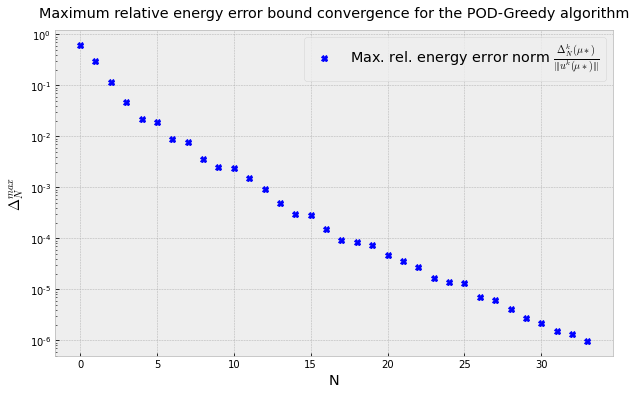

In [102]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(DeltaMaxRel, "bX", label="Max. rel. energy error norm $ \\frac{\Delta_N^k(\mu*)}{|\!|\!|u^k(\mu*)|\!|\!|}$")

ax.set_xlabel("N", fontsize="x-large")
ax.set_ylabel("$\\Delta_N^{max}$", fontsize="x-large")
ax.set_yscale("log")
ax.set_title("Maximum relative energy error bound convergence for the POD-Greedy algorithm", fontsize="x-large", y=1.02)
ax.legend(fontsize="x-large");

### c) Let's plot the outputs 

In [103]:
## A wrapper function that computes and plot the outputs, its errors, and the error bound

def testOutput(Z, title=None):
    K = 100
    tMax = 10
    N = 10
    Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)

    kStop = K

    UhParams = {"mu":buildMu(0.05), "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fh),
                "Aq":Ahq, "F":Fh, "M":Mh,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"FE"}
    UnParams = {"mu":buildMu(0.05), "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fn),
                "Aq":Anq, "F":Fn, "M":Mn,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"RB"}

    Uh, UhList = computeSolution(**UhParams)
    Un, UnList = computeSolution(**UnParams)

    outputsFE = np.empty((kStop+1))
    outputsRB = np.empty((kStop+1))
    outputErrors = np.empty((kStop+1))
    for k in range(0, kStop+1):
        outputsFE[k] = computeOutput(Lh, UhList[:, k])
        outputsRB[k] = computeOutput(Ln, UnList[:, k])
        outputErrors[k] = np.abs(outputsFE[k] - outputsRB[k])

    ###----------------------------------------------------------------------

    RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Z}
    CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)

    baseUnParams = UnParams.copy()
    K = baseUnParams["K"]
    nStepsToPlot = K
    onOffOutputData = np.zeros((nStepsToPlot+1))

    baseOutputParams = {"mu":baseUnParams['mu'], 
                        "k":baseUnParams['K'], 
                        "UnList":UnList, 
                        "g":baseUnParams["g"], 
                        "K":baseUnParams["K"], 
                        "tMax":baseUnParams["tMax"], 
                        "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

    for k in (range(1, K+1)):
      onOffOutputData[k] = outputErrorBound(baseOutputParams, Mh, lHatNorm, k)
    onOffOutputData[0] = np.nan

    ###----------------------------------------------------------------------

    time = np.linspace(0, tMax, K+1)

    fig,ax = plt.subplots(1,2,figsize=(10*2,5))
    ax[0].plot(time, outputsFE, "r*", label="Truth output $s^k(\mu)$")
    ax[0].plot(time, outputsRB, "g.", label="Approximate output $s^k_N(\mu)$")

    ax[0].set_xlabel("Time", fontsize="x-large")
    ax[0].set_ylabel("Output", fontsize="x-large")
    # ax[0].set_yscale("log")
    ax[0].set_title("Output comparison in FE and RB spaces", fontsize="x-large", y=1.02)
    ax[0].legend(fontsize="x-large");

    ax[1].plot(time, outputErrors, "mX", label="Output error $\\vert s^k(\mu) - s^k_N(\mu) \\vert$")
    ax[1].plot(time, onOffOutputData, "y.-", label=" Output error bound $\\Delta_N^{k,s}(\mu)$")

    ax[1].set_xlabel("Time", fontsize="x-large")
    ax[1].set_ylabel("Outout error", fontsize="x-large")
    ax[1].set_yscale("log")
    ax[1].set_title("Outout error and output error bound", fontsize="x-large", y=1.02)
    ax[1].legend(fontsize="x-large");

    plt.suptitle(title, fontsize="xx-large")

#### For $N=10$

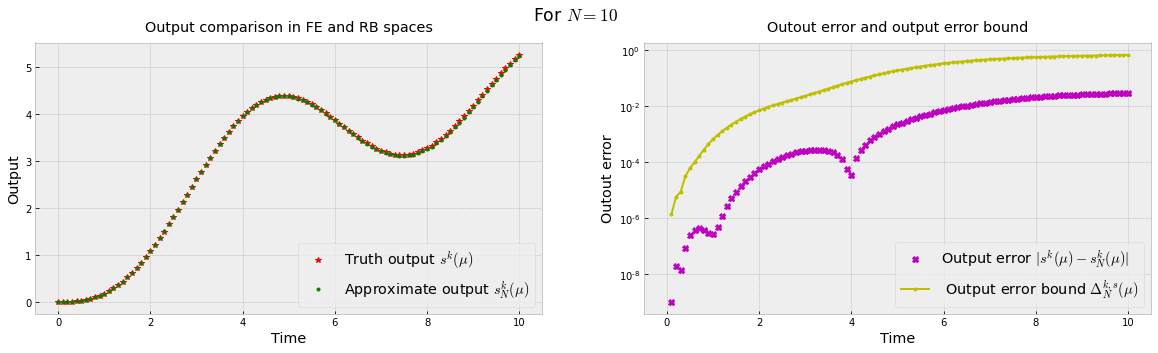

In [104]:
N = 10
Z = ZGreedy[:,:N]

testOutput(Z, title="For $N=10$")

It is clear that the results are better here. That is when compared to the ones we obtained in Part 1-a), where we also had $N=10$. 

#### For $N=N_{max}$

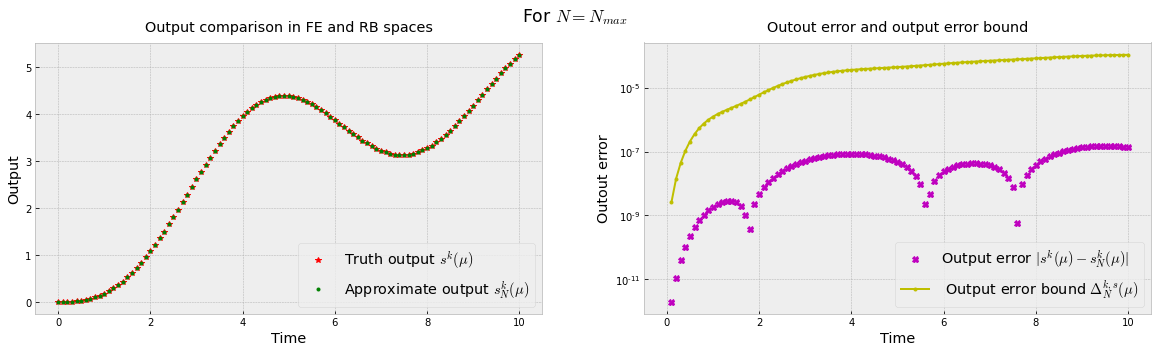

In [105]:
testOutput(ZGreedy, title="For $N=N_{max}$")

Increasing the value of $N$ only makes the approximation better. We can see that the output error is considerably smaller compared to the case just above ($N=10$). This is an indication that our implementation is correct.

### d) Let's plot the field variables

In [106]:
## A wrapper function that computes and plot the energy errors

def testErrors(Z, title=None):
    K = 100
    tMax = 10
    Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)

    kStop = K

    UhParams = {"mu":buildMu(0.05), "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fh),
                "Aq":Ahq, "F":Fh, "M":Mh,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"FE"}
    UnParams = {"mu":buildMu(0.05), "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fn),
                "Aq":Anq, "F":Fn, "M":Mn,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"RB"}

    Uh, UhList = computeSolution(**UhParams)
    Un, UnList = computeSolution(**UnParams)

    enNormsFE = np.empty((kStop+1))
    enNormsRB = np.empty((kStop+1))
    enNormErrors = np.empty((kStop+1))

    mu = buildMu(0.05)
    A = assembleA(mu, Ahq)
    dt = tMax / K

    for k in range(0, kStop+1):
      enNormsFE[k] = energyNorm(UhList, Mh, A, dt, k)
      enNormsRB[k] = energyNorm(Z@UnList, Mh, A, dt, k)
      enNormErrors[k] = energyNorm(UhList-Z@UnList, Mh, A, dt, k)

    ###----------------------------------------------------------------------

    RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Z}
    CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)

    nStepsToPlot = K
    errorBoundData = np.zeros((nStepsToPlot+1))

    baseErrorBoundParams = {"mu":mu, 
                            "k":None, 
                            "UnList":UnList, 
                            "g":gCos(np.linspace(0,tMax,K+1)), 
                            "K":K, 
                            "tMax":tMax, 
                            "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

    for k in (range(1, K+1)):
        errorBoundData[k] = offlineOnlineErrorBound(baseErrorBoundParams, k)
    errorBoundData[0] = np.nan

    ###----------------------------------------------------------------------

    time = np.linspace(0, tMax, K+1)

    fig,ax = plt.subplots(1,2,figsize=(10*2,5))
    ax[0].plot(time, enNormsFE, "r*", label="Truth solution $|\!|\!|u^k(\mu)|\!|\!|$")
    ax[0].plot(time, enNormsRB, "g.", label="Approximate solution $|\!|\!|u^k_N(\mu)|\!|\!|$")

    ax[0].set_xlabel("Time", fontsize="x-large")
    ax[0].set_ylabel("Energy norm", fontsize="x-large")
    # ax[0].set_yscale("log")
    ax[0].set_title("Energy norm comparison in FE and RB spaces", fontsize="x-large", y=1.02)
    ax[0].legend(fontsize="x-large");

    ax[1].plot(time, enNormErrors, "mX", label="Energy norm error $|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|$")
    ax[1].plot(time, errorBoundData, "y.-", label=" Energy error bound $\\Delta_N^{k}(\mu)$")

    ax[1].set_xlabel("Time", fontsize="x-large")
    ax[1].set_ylabel("Energy norm bound", fontsize="x-large")
    ax[1].set_yscale("log")
    ax[1].set_title("Energy norm error and bound", fontsize="x-large", y=1.02)
    ax[1].legend(fontsize="x-large");

    plt.suptitle(title, fontsize="xx-large")

#### For $N=10$

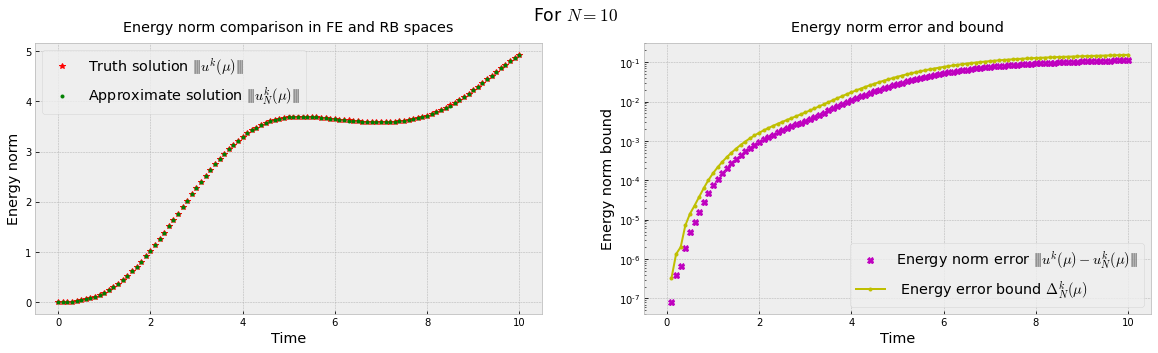

In [107]:
N = 10
Z = ZGreedy[:,:N]

testErrors(Z, title="For $N=10$")

#### For $N=N_{max}$

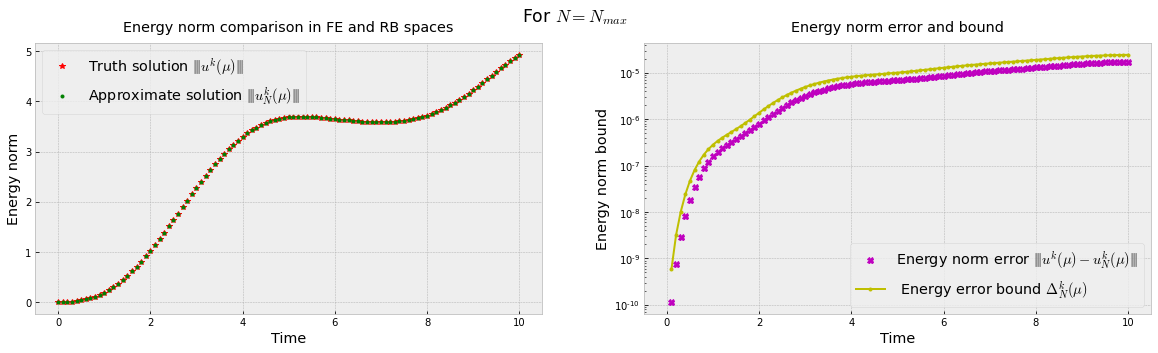

In [108]:
testErrors(ZGreedy, title="For $N=N_{max}$")

The errors can be as small as $1e-10$. These two plots confirm that the carefully constructed POD-greedy sample is far better than the randomly selected sample used in Part 1-b).

### e) Average effectivities

The effectivity we used is an average over the test sample and the time steps.
$$
\bar{\eta}^{\mu} = \frac{1}{n_{test}\, K} \sum_{\mu \in TestSample} \sum_{k=1}^K \frac{\Delta^k_N (\mu)}{|\!|\!| u^k(\mu) - u^k_N(\mu) |\!|\!|}
$$

In [109]:
### For safety, let's rebuild our offline quantities 
RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":ZGreedy}
CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)

In [110]:
%%time

baseUhParams = {"mu":None, "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fh),
                "Aq":Ahq, "F":Fh, "M":Mh,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"FE"}

baseUnParams = {"mu":None, "K":K, "tMax":tMax, "kStop":kStop, "U0":None,
                "Aq":None, "F":None, "M":None,
                "g":gCos(np.linspace(0,tMax,K+1)),
                "which":"RB"}

baseOnlineOfflineParams = {"mu":baseUnParams['mu'], 
                            "k":baseUnParams['K'], 
                            "UnList":UnList, 
                            "g":baseUnParams["g"], 
                            "K":baseUnParams["K"], 
                            "tMax":baseUnParams["tMax"], 
                            "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

nTest = 15
BiVals = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTest)))

K = 100
tMax = 10
kStop = 100

Nmax = ZGreedy.shape[1]
K = baseUnParams["K"]
nStepsToPlot = K
effectivities = np.zeros((Nmax, nTest, nStepsToPlot))

for i, Bi in enumerate(BiVals):

    mu = buildMu(Bi)

    baseUhParams["mu"] = mu
    Uh, UhList = computeSolution(**baseUhParams)

    for N in range(1, Nmax+1):

        Z = ZGreedy[:, :N]
        Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)

        baseUnParams["Aq"] = Anq
        baseUnParams["F"] = Fn
        baseUnParams["M"] = Mn
        baseUnParams["mu"] = mu
        baseUnParams["U0"] = np.zeros_like(Fn)
        Un, UnList = computeSolution(**baseUnParams)

        baseOnlineOfflineParams["mu"] = baseUnParams["mu"]
        baseOnlineOfflineParams["UnList"] = UnList

        Ah = assembleA(mu, Ahq)
        dt = tMax / K

        for k in range(1, K+1):
            enNormError = energyNorm(UhList-Z@UnList, Mh, Ah, dt, k)
            effectivities[N-1, i, k-1] = offlineOnlineErrorBound(baseOnlineOfflineParams, k) / enNormError

effMean = np.mean(np.mean(effectivities, axis=2), axis=1)

In [111]:
print("Average effectivity for selected sizes:", effMean[[0, 9, 19, 29]])

Average effectivity for selected sizes: [1.98526097 1.83774132 1.70646955        nan]


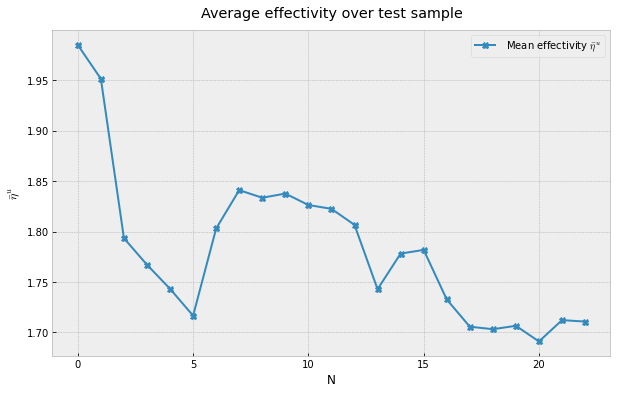

In [112]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(effMean, "X-", label=" Mean effectivity $\\bar{\eta}^u$")

ax.set_xlabel("N", fontsize="large")
ax.set_ylabel("$\\bar{\eta}^u$", fontsize="large")
# ax.set_yscale("log")
ax.set_title("Average effectivity over test sample", fontsize="x-large", y=1.02)
ax.legend();

We can observe an overall increase in sharpness as the size of the RB basis grows. Notice that some values have been reported as NaN (due to the online summation for the Riesz representation too close to $0$, e.g. $-1e-21$), thus returning NaN when the square root is taken.

### f) Average time comparison

First, let's chose $N$ based on (b) such that the error in the output error bound is approximately 1%.

In [133]:
### Helper function to compute the output error bound
def testOutputModified(Z, mu, title=None):
    K = 100
    tMax = 10
    Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)
    kStop = K

    baseUnParams = {"mu":mu, "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fn),
                    "Aq":Anq, "F":Fn, "M":Mn,
                    "g":gCos(np.linspace(0,tMax,K+1)),
                    "which":"RB"}

    Un, UnList = computeSolution(**baseUnParams)

    onOffOutputData = np.zeros((K+1))

    RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Z}
    CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)

    baseOutputParams = {"mu":mu, 
                        "k":K, 
                        "UnList":UnList, 
                        "g":gCos(np.linspace(0,tMax,K+1)), 
                        "K":K, 
                        "tMax":tMax, 
                        "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

    for k in (range(1, K+1)):
        onOffOutputData[k] = outputErrorBound(baseOutputParams, Mh, lHatNorm, k)

    return np.mean(onOffOutputData)

In [134]:
%%time

###### Find a 3 % error

nTest = 4     ### SET THIS AT 15 FOR BETTER PRECISION ###
BiVals = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTest)))

N = 2
outErr = 100
error = 100
while error > 3e-2 and N < ZGreedy.shape[1]:

  Z = ZGreedy[:, :N]
  temp = []
  for Bi in BiVals:
    temp.append(testOutputModified(Z, buildMu(Bi)))
  
  newOutErr = np.mean(np.array(temp))
  error = np.abs(newOutErr - outErr) / np.abs(outErr)

  outErr = newOutErr
  print("N:", N, "    Output error: %0.3f"%(error*100)+" %")

  N += 1

N: 2     Output error: 95.616 %
N: 3     Output error: 54.877 %
N: 4     Output error: 29.555 %
N: 5     Output error: 10.027 %
N: 6     Output error: 1.809 %
CPU times: user 2min 17s, sys: 1min 38s, total: 3min 55s
Wall time: 1min 59s


We can see that $N$ most be close to 6 for us to have an output error bound accuracy of 1.8 %. Now we can launch the time comparison.


In [138]:
def timerOutputFE():
  Uh, UhList = computeSolution(**UhParams)
  computeOutput(Lh, UhList[:, k])

def timerOutputRB():
  Un, UnList = computeSolution(**UnParams)
  computeOutput(Ln, UnList[:, k])
  baseOutputParams["UnList"] = UnList
  outputErrorBound(baseOutputParams, Mh, lHatNorm, k)

In [144]:
%%time

Z = Z[:, :N]

K = 100
tMax = 10
Anq, Fn, Ln, Mn = buildOfflineRBQuantities(Z, Ahq, Fh, Lh, Mh)
kStop = 100

nTest = 6           #######------- Change this to 15 for better precision ------######
BiVals = np.exp(np.random.uniform(np.log(0.01), np.log(1), size=(nTest)))

outputsFE = np.empty((nTest, kStop))
outputsRB = np.empty((nTest, kStop))

UhParams = {"mu":None, "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fh),
            "Aq":Ahq, "F":Fh, "M":Mh,
            "g":gCos(np.linspace(0,tMax,K+1)),
            "which":"FE"}
UnParams = {"mu":None, "K":K, "tMax":tMax, "kStop":kStop, "U0":np.zeros_like(Fn),
            "Aq":Anq, "F":Fn, "M":Mn,
            "g":gCos(np.linspace(0,tMax,K+1)),
            "which":"RB"}

RieszOfflineParams = {"Ahq":Ahq, "Fh":Fh, "Mh":Mh, "AhBar":AhBar, "Z":Z}
CC, CR, RR, CL, RL, LL = buildOfflineRieszQuantities(**RieszOfflineParams)

baseOutputParams = {"mu":baseUnParams['mu'], 
                    "k":baseUnParams['K'], 
                    "UnList":UnList, 
                    "g":baseUnParams["g"], 
                    "K":baseUnParams["K"], 
                    "tMax":baseUnParams["tMax"], 
                    "CC":CC, "CR":CR, "RR":RR, "CL":CL, "RL":RL, "LL":LL}

for i, Bi in enumerate(BiVals):
    mu = buildMu(Bi)
    UhParams["mu"] = mu
    UnParams["mu"] = mu
    baseOutputParams["mu"] = mu

    for k in (range(1, kStop+1)):
        k = k
        outputsFE[i, k-1] = timeit.timeit(timerOutputFE, number=3)
        outputsRB[i, k-1] = timeit.timeit(timerOutputRB, number=3)

timesFE = np.mean(outputsFE, axis=0)
timesRB = np.mean(outputsRB, axis=0)

CPU times: user 5min 36s, sys: 3min 4s, total: 8min 40s
Wall time: 5min 5s


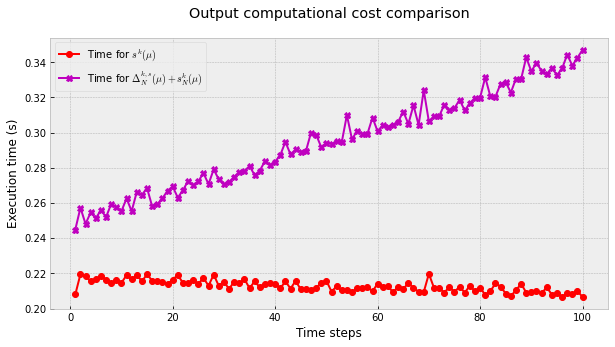

In [145]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

t = np.arange(1, kStop+1)
ax.plot(t, timesFE, "ro-", label="Time for $s^k(\mu)$")
ax.plot(t, timesRB, "mX-", label="Time for $\Delta^{k,s}_N(\mu) + s_N^k(\mu)$")
ax.set_xlabel("Time steps")
ax.set_ylabel("Execution time (s)")
# ax.set_yscale("log")
ax.set_title("Output computational cost comparison", y=1.05)
ax.legend();

For this particular case (and the required accuracy), the exact computation is faster than the approximate calculation. The same comparison with lower values for $N$ (thus worse accuracy) is likely to show better performance for the offline-online approach.